In [75]:
%matplotlib inline
import numpy as np
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
from typing import List
from datetime import date

In [225]:
class ForwardPrice:
    """
    An observed price for some delivery time T
    """
    def __init__(self, T, P):
        self.T = T
        self.P = P
        
class ForwardPriceCurve:
    """
    A collection of prices for various delivery times, observed at some time
    """
    def __init__(self, observation_time: Number, forward_prices: List[ForwardPrice]):
        self.observation_time = observation_time
        self.forward_prices = forward_prices
        
    
    def remove_deliveries_expiring_before(self, boundary):
        return ForwardPriceCurve(
            self.observation_time,
            [fp for fp in self.forward_prices if fp.T >= boundary]
        )
    
    @property
    def delivery_times(self):
        return [fp.T for fp in self.forward_prices]
    
    @property
    def prices(self):
        return [fp.P for fp in self.forward_prices]
    
    def draw_absolute_curve(self):
        fig, ax = plt.subplots()
        line, = ax.plot([])
        ax.set_xlim(0, self.delivery_times[-1])
        ax.set_ylim(0, np.max(self.prices) * 1.2)
        ax.set_xlabel("Time since 28th Jan in years")
        ax.set_ylabel("TTF Price")
        line.set_data(self.delivery_times, self.prices)
        plt.show()
        
    def draw_relative_curve(self):
        fig, ax = plt.subplots()
        line, = ax.plot([])
        ax.set_xlim(0, self.delivery_times[-1] - self.observation_time)
        ax.set_ylim(0, np.max(self.prices) * 1.2)
        ax.set_xlabel("Relative time")
        ax.set_ylabel("TTF Price")
        line.set_data([T - self.observation_time for T in self.delivery_times], self.prices)
        plt.show()
    


TTF_28_JAN_PRICES = {
    date(2022, 1, 29):90.50, date(2022, 1, 30):90.50, date(2022, 1, 31):90.70, date(2022, 2, 1):91.07, date(2022, 2, 28):91.07,
    date(2022, 3, 1):90.82, date(2022, 4, 1):87.50, date(2022, 5, 1):86.55, date(2022, 6, 1):86.37, date(2022, 7, 1):86.17,
    date(2022, 8, 1):85.97, date(2022, 9, 1):85.97, date(2022, 10, 1):86.50, date(2022, 11, 1):87.17, date(2022, 12, 1):87.66,
    date(2023, 1, 1):87.85, date(2023, 2, 1):87.83, date(2023, 3, 1):82.82, date(2023, 4, 1):49.50, date(2023, 5, 1):45.50,
    date(2023, 6, 1):44.90, date(2023, 7, 1):44.56, date(2023, 8, 1):44.61, date(2023, 9, 1):44.70, date(2023, 10, 1):44.97,
    date(2023, 11, 1):46.10, date(2023, 12, 1):46.59, date(2024, 1, 1):46.11, date(2024, 2, 1):46.14, date(2024, 3, 1):45.00,
    date(2024, 4, 1):34.00, date(2024, 5, 1):31.57, date(2024, 6, 1):30.74, date(2024, 7, 1):30.99, date(2024, 8, 1):30.92,
    date(2024, 9, 1):31.20, date(2024, 10, 1):31.66, date(2024, 11, 1):32.56, date(2024, 12, 1):32.93, date(2025, 1, 1):33.11,
    date(2025, 2, 1):32.80, date(2025, 3, 1):31.91, date(2025, 4, 1):28.03, date(2025, 5, 1):27.25, date(2025, 6, 1):26.72,
    date(2025, 7, 1):26.50, date(2025, 8, 1):26.66, date(2025, 9, 1):26.79, date(2025, 10, 1):27.69, date(2025, 11, 1):28.37,
    date(2025, 12, 1):29.04
}

PRICING_DATE = date(2022, 1, 28)
delivery_dates = sorted(TTF_28_JAN_PRICES)
TTF_28_JAN_FPC = ForwardPriceCurve(
    observation_time = 0.0,
    forward_prices = [ForwardPrice(T=(d - PRICING_DATE).days / 365.0, P = TTF_28_JAN_PRICES[d]) for d in delivery_dates]
)

In [43]:
from abc import ABC, abstractmethod
from numbers import Number

class PriceProcess(ABC):
    def __init__(self):
        self.rng = np.random.default_rng()
        
    @abstractmethod
    def evolve(fpc: ForwardPriceCurve, next_observation_time: Number):
        """ randomly perturb the forward curve"""
  

In [185]:
class LognormalProcessWithExponentialDecay(PriceProcess):
    def __init__(self, alphas: List[Number], vols: List[Number]):
        super().__init__()
        self.alphas = alphas
        self.vols = vols

    def evolve(self, fpc, next_observation_time):
        
        dt = next_observation_time - fpc.observation_time
        t = (fpc.observation_time + next_observation_time) / 2.0
        dzs = [self.rng.normal(scale=np.sqrt(dt)) for _ in range(len(self.alphas))]
        live_fpc = fpc.remove_deliveries_expiring_before(next_observation_time)

        def risk_adj(s):
            return 0.5 * s * s * dt
        
        evolved_prices = []
        for fp in live_fpc.forward_prices:
            evolved_price = fp.P
            for dz, alpha, vol in zip(dzs, self.alphas, self.vols):
                scaled_vol = np.exp(-alpha * (fp.T - t)) * vol
                evolved_price *= np.exp(scaled_vol * dz  - risk_adj(scaled_vol))
            evolved_prices.append(ForwardPrice(fp.T, evolved_price))
            
        return ForwardPriceCurve(
            next_observation_time,
            evolved_prices
        )
                                
        

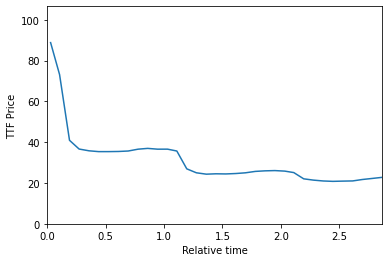

In [226]:
fpc = TTF_28_JAN_FPC
process = LognormalProcessWithExponentialDecay(
    alphas=[0, 0.9, 10],
    vols=[0.2, 0.6, 0.5]
)
observation_times = [i / 52.0 for i in range(53)]

for t in observation_times:
    fpc.draw_relative_curve()
    clear_output(wait=True)
    sleep(0.1)
    fpc = process.evolve(fpc, t)